# 机器学习的实例-猫图像识别

通过猫图像识别的实例，实现以下目的：
- 了解机器学习中的监督学习、监督学习中的神经网络、神经网络中的浅网络和深网络的主要理论知识。
- 编程实现这个猫识别机器学习算法。
- 了解理论和编程所需的主要前置知识，比如微积分、线性代数、概率统计、python、tensorflow等。

## 任务

猫图像识别：输入一张图片，输出这张图片是否是猫。

## 数据集

### 获取

数据集从吴恩达的深度学习课程里的编程作业的jupyter notebook里获得。数据集情况如下：

- 数据集是一些图片，图片是64*64像素大小的RBG图片。
- 每个图片带一个标签，标注其是否是猫。
- 数据集分为训练集和测试集。
- 数据集用hdf5的格式存储，hdf5中包含dataset元素。
- 训练集：
    - 文件：datasets/train_catvnoncat.h5
    - dataset: train_set_x，表示特征
        - 维度：209 * 64 * 64 * 3，209是图片数
    - dataset: train_set_y，表示标签，值为0或1
        - 维度：209
    - dataset: list_classes，表示标签对应的类，0对应non-cat，1对应cat
- 测试集：
    - 文件：datasets/test_catvnoncat.h5
    - 样本数为50，其他和训练集一样

### 加载

加载指从某些地方（比如磁盘）将数据集写入内存。广义的加载，也可能不一定马上写入内存，而是构建了一个输入数据流。

In [46]:
import h5py

def load_dataset():
    with h5py.File("datasets/train_catvnoncat.h5", "r") as train_dataset:
        print("dataset type is {}".format(type(train_dataset["train_set_x"][:])))
        train_set_x = train_dataset["train_set_x"][:]
        print("train set x shape is {}".format(train_set_x.shape))
        train_set_y = train_dataset["train_set_y"][:]
        print("train set y shape is {}".format(train_set_y.shape))
    with h5py.File("datasets/test_catvnoncat.h5", "r") as test_dataset:
        test_set_x = test_dataset["test_set_x"][:]
        print("test set x shape is {}".format(test_set_x.shape))
        test_set_y = test_dataset["test_set_y"][:]
        print("test set y shape is {}".format(test_set_y.shape))
        class_list = test_dataset["list_classes"][:]
        print("class list is {}".format(class_list))
    return train_set_x,train_set_y,test_set_x,test_set_y,class_list
train_set_x,train_set_y,test_set_x,test_set_y,class_list = load_dataset()

dataset type is <class 'numpy.ndarray'>
train set x shape is (209, 64, 64, 3)
train set y shape is (209,)
test set x shape is (50, 64, 64, 3)
test set y shape is (50,)
class list is [b'non-cat' b'cat']


### 探索

探索指观察数据集中的若干样本，使我们对数据有直观的了解。

start is 11


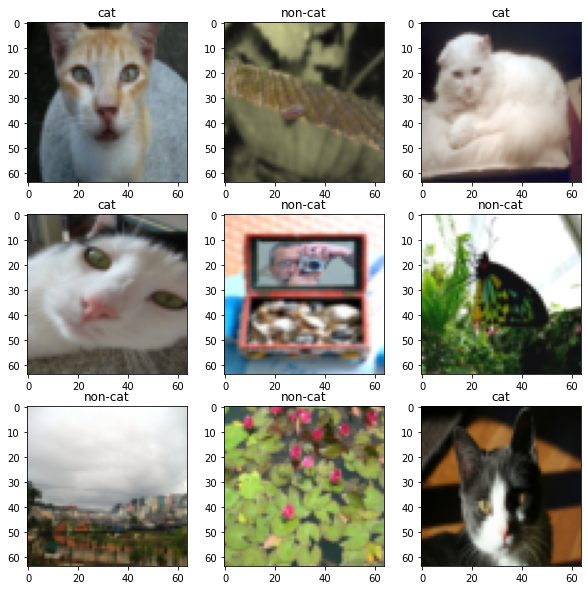

In [47]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10,10))
show_num = 9
start = int(random.random() * train_set_x.shape[0] - show_num)
print('start is {}'.format(start))
for i in range(show_num):
    plt.subplot(3,3,i+1)
    plt.imshow(train_set_x[start + i])
    plt.title(class_list[train_set_y[start + i]].decode('utf-8'))

### 预处理

#### 变平(flatten)

将(x,y,z)变成(x\*y\*z,1)

#### 标准化(standardize)

对于图像来说，像素由3个数值组成，数值的范围是[0,255]，其标准化方法是将每个值除以255.

In [42]:
train_set_x_stand = train_set_x / 255
test_set_x_stand = test_set_x / 255
train_set_x_stand

array([[[[0.06666667, 0.12156863, 0.21960784],
         [0.08627451, 0.12941176, 0.23137255],
         [0.09803922, 0.1372549 , 0.24313725],
         ...,
         [0.00392157, 0.10980392, 0.22352941],
         [0.00392157, 0.10196078, 0.21960784],
         [0.00392157, 0.08627451, 0.2       ]],

        [[0.09803922, 0.14117647, 0.24313725],
         [0.10980392, 0.14901961, 0.25098039],
         [0.11764706, 0.15686275, 0.2627451 ],
         ...,
         [0.00392157, 0.10588235, 0.21960784],
         [0.00392157, 0.09803922, 0.21568627],
         [0.00784314, 0.08235294, 0.2       ]],

        [[0.1254902 , 0.15686275, 0.2627451 ],
         [0.13333333, 0.16470588, 0.27058824],
         [0.1372549 , 0.16470588, 0.2745098 ],
         ...,
         [0.00392157, 0.09803922, 0.21568627],
         [0.        , 0.09411765, 0.21176471],
         [0.00392157, 0.08235294, 0.2       ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

## 模型

我们先使用逻辑回归(Logistic Regression,LR)作为模型。

### 构建

#### 模型的表示

图形化表示：

<img src="images/LogReg_kiank.png" style="width:550px;height:350px;">

公式表示：

对于每个样本$i$:

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y} = \sigma(z^{(i)}) = sigmoid(z^{(i)}) = {{1} \over {(1+e^{-z^{(i)}})\tag{2}}}$$

$(1)$这里涉及向量乘法运算，参考"线性代数"一文。

#### Loss Function

$$L(\hat{y}^{(i)},y^{(i)}) = -y^{(i)}log(\hat{y}^{(i)}) - (1-y^{(i)})log(1-\hat{y}^{(i)}) \tag{3}$$
$$J=\frac{1}{m} \displaystyle \sum_{m=1}^m{L(\hat{y}^{(i)},y^{(i)})} \tag{4}$$

$(3)$涉及交叉熵 (Cross Entropy)，参考"信息论"一文。

#### 正则化 @todo

### 训练

#### 梯度下降

### 评估

#### 衡量指标